In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import scienceplots

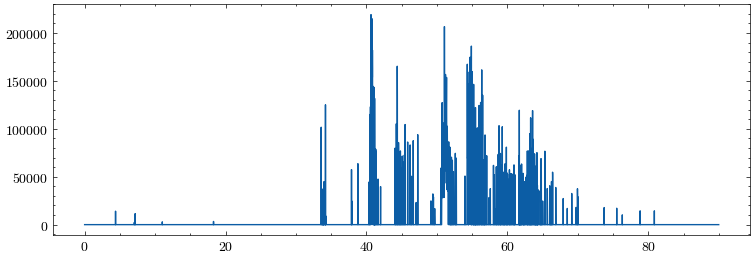

In [2]:
data = pd.read_csv('../sample_data/4502.csv')

plt.style.use(['science', 'no-latex'])
# Visualize the rough EIC
plt.figure(figsize=(9, 3))
plt.plot(data['RT'], data['Intensity'])

Epoch 1/100


c:\Users\Vishal\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0050 - val_loss: 1.2521e-05
Epoch 2/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 1.0682e-05
Epoch 3/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 1.0679e-05
Epoch 4/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 1.0682e-05
Epoch 5/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 1.0822e-05
Epoch 6/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0023 - val_loss: 1.0584e-05
Epoch 7/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0023 - val_loss: 1.2824e-05
Epoch 8/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0022 - val_loss: 1.1060e-05
Epoch 9/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0022 - val_loss: 1.3887e-05
Epoch 10/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - val_loss: 1.0557e-05
Epoch 11/100
324/324 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0021 - val_loss: 9.7954e-06
Epoch 12/

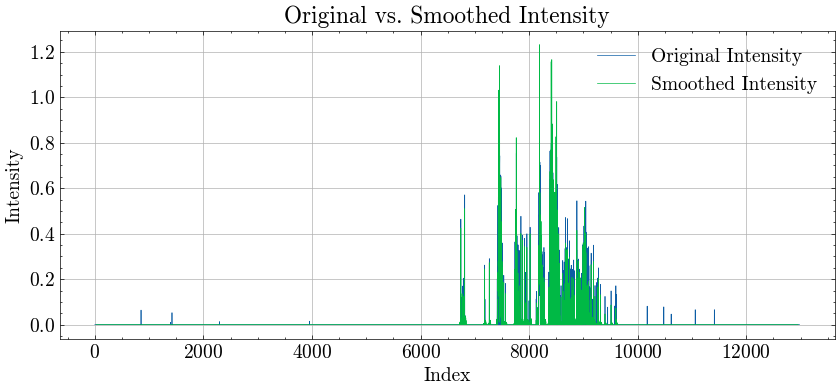

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Load the data
data = pd.read_csv('../sample_data/4502.csv')

# Normalize the intensity values
scaler = MinMaxScaler()
data['Intensity'] = scaler.fit_transform(data['Intensity'].values.reshape(-1, 1))

# Function to create sliding windows
def create_sliding_window(data, window_size=5):
    """
    Creates sliding windows from intensity values.
    Each window contains `window_size` consecutive intensity values.
    """
    X = []
    for i in range(len(data) - window_size + 1):
        X.append(data['Intensity'].iloc[i:i + window_size].values)
    return np.array(X)

# Define window size
window_size = 50
X = create_sliding_window(data, window_size)

# Define the autoencoder structure
input_dim = X.shape[1]  # Number of features per input (size of sliding window)

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(256)(input_layer)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = Dropout(0.3)(encoded)
encoded = Dense(128)(encoded)
encoded = LeakyReLU(alpha=0.01)(encoded)
encoded = BatchNormalization()(encoded)
encoded = Dense(64, activation='relu')(encoded)  # Bottleneck

# Decoder
decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

# Combine encoder and decoder to create autoencoder
autoencoder = Model(input_layer, decoded)

# Compile the model with mean squared error (MSE) loss and Adam optimizer
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(X, X, epochs=100, batch_size=32, shuffle=True, validation_split=0.2)

# Predict denoised data
denoised_data = autoencoder.predict(X)

# Reconstruct smoothed intensities from denoised sliding windows
# Take the center value from each sliding window for reconstruction
smoothed_intensities = [denoised_data[i][window_size // 2] for i in range(len(denoised_data))]

# Adjust lengths to align with the original data
padding_start = (window_size - 1) // 2
padding_end = len(data) - len(smoothed_intensities) - padding_start

smoothed_intensities = np.concatenate((
    np.full(padding_start, np.nan),  # Padding at the start
    smoothed_intensities,           # Smoothed values
    np.full(padding_end, np.nan)    # Padding at the end
))

# Clip negative values to 0
smoothed_intensities = np.clip(smoothed_intensities, 0, None)

# Add smoothed intensities to the original dataframe
data['smoothed_intensity'] = smoothed_intensities

# Visualize the results
plt.figure(figsize=(10, 4))
plt.plot(data['Intensity'], label='Original Intensity', linewidth = 0.5)
plt.plot(data['smoothed_intensity'], label='Smoothed Intensity', linewidth = 0.5)
plt.xlabel('Index')
plt.ylabel('Intensity')
plt.title('Original vs. Smoothed Intensity')
plt.legend()
plt.grid(True)
plt.show()


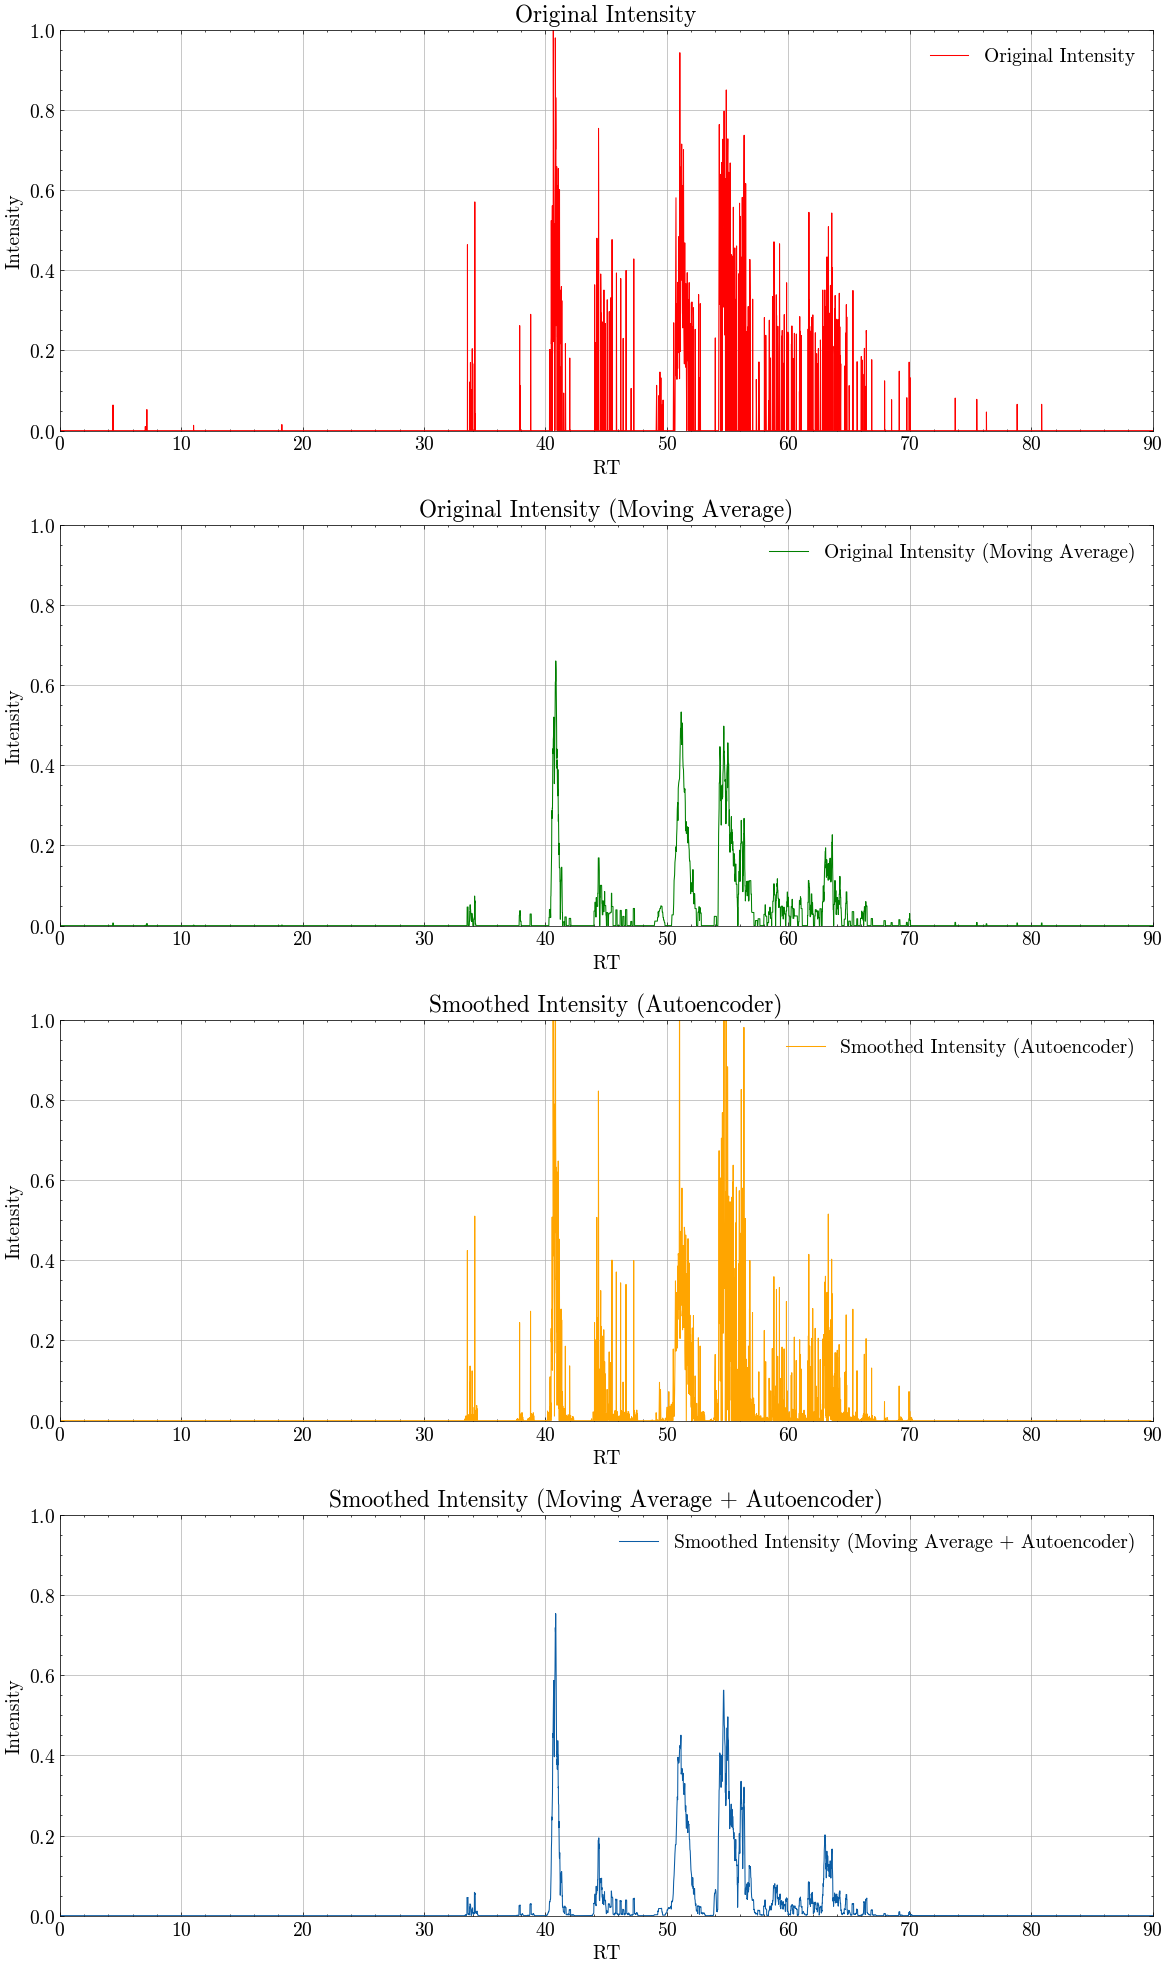

In [18]:
def moving_average(data, window_size=5):
    """
    Apply a moving average filter to the data.
    """
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

# Apply moving average to the smoothed intensities
data['smoothed_intensity_ma'] = moving_average(data['smoothed_intensity'].fillna(0), window_size=10)
data['intensity_ma'] = moving_average(data['Intensity'], window_size=10)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 20))

# First subplot: Smoothed Intensity (Moving Average)
plt.subplot(4, 1, 4)  # 1 row, 2 columns, 1st subplot
plt.plot(data['RT'], data['smoothed_intensity_ma'], label='Smoothed Intensity (Moving Average + Autoencoder)', linewidth=0.75)
plt.xlabel('RT')
plt.ylabel('Intensity')
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.xlim(0, 90)
plt.ylim(0, 1)  # Limit y-axis to 0-1

plt.title('Smoothed Intensity (Moving Average + Autoencoder)')
plt.legend()
plt.grid(True)

# Second subplot: Smoothed Intensity (Autoencoder)
plt.subplot(4, 1, 3)  # 1 row, 2 columns, 2nd subplot
plt.plot(data['RT'], data['smoothed_intensity'], label='Smoothed Intensity (Autoencoder)', linewidth=0.75, color='orange')
plt.xlabel('RT')
plt.ylim(0, 1)  # Limit y-axis to 0-1
plt.ylabel('Intensity')
plt.title('Smoothed Intensity (Autoencoder)')
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.legend()
plt.xlim(0, 90)
plt.grid(True)

# Third subplot: Original Intensity
plt.subplot(4, 1, 1)  # 1 row, 2 columns, 2nd subplot
plt.plot(data['RT'], data['Intensity'], label='Original Intensity', linewidth=0.75, color='red')
plt.xlabel('RT')
plt.ylabel('Intensity')
plt.title('Original Intensity')
plt.legend()
plt.ylim(0, 1)  # Limit y-axis to 0-1
plt.xlim(0, 90)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.grid(True)

# Fourth subplot: Original Intensity (Moving Average)
plt.subplot(4, 1, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(data['RT'], data['intensity_ma'], label='Original Intensity (Moving Average)', linewidth=0.75, color='green')
plt.xlabel('RT')
plt.ylabel('Intensity')
plt.title('Original Intensity (Moving Average)')
plt.legend()
plt.ylim(0, 1)  # Limit y-axis to 0-1
plt.xlim(0, 90)
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
plt.grid(True)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('autoencoder_smoothed_eic.png', dpi=300)
plt.show()

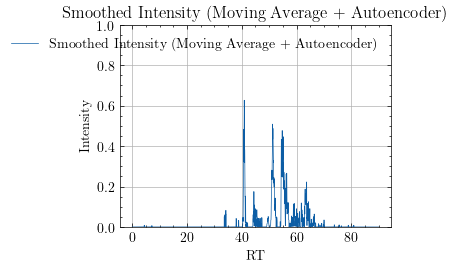

In [79]:
plt.plot(data['RT'], data['smoothed_intensity_ma'], label='Smoothed Intensity (Moving Average + Autoencoder)', linewidth=0.5)
plt.xlabel('RT')
plt.ylabel('Intensity')
plt.ylim(0, 1)  # Limit y-axis to 0-1
plt.title('Smoothed Intensity (Moving Average + Autoencoder)')
plt.legend()
plt.grid(True)
